* Course: DSC640
* Title: MileStone Project
* Author Nels Findley
* 11/23/2025
* Description: MileStone Project

In [21]:
# Setup libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import altair as alt

In [22]:
# load dataset and view it
df = pd.read_excel('nationaldatabaseofchildcareprices.xlsx')

In [23]:
# Select necessary columns
state_data = df[['State_Name', 'PR_P', 'MCInfant']].copy()

# calculate median
state_agg = state_data.groupby('State_Name').median().reset_index()

# Rename column
state_agg.rename(columns={
    'PR_P': 'Median_Poverty_Rate',
    'MCInfant': 'Median_Childcare_Cost_Infant'
}, inplace=True)

#Drop rows with missing data
state_agg.dropna(subset=['Median_Childcare_Cost_Infant'], inplace=True)

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the two variables
state_agg['Poverty_Rate_Norm'] = scaler.fit_transform(
    state_agg[['Median_Poverty_Rate']]
)
state_agg['Childcare_Cost_Norm'] = scaler.fit_transform(
    state_agg[['Median_Childcare_Cost_Infant']]
)

# Calculate the Composite Disparity-Cost Index
state_agg['Composite_Index'] = (
    state_agg['Poverty_Rate_Norm'] * state_agg['Childcare_Cost_Norm']
)

# Sort the states by the composite index and calculate the rank
state_agg_sorted = state_agg.sort_values(
    'Composite_Index', ascending=False
).reset_index(drop=True)

# Calculate the overall rank for all states
state_agg_sorted['Rank'] = state_agg_sorted['Composite_Index'].rank(method='min', ascending=False).astype(int)

# Extract Top 10 and Bottom 10
top_10 = state_agg_sorted.head(10).copy()
bottom_10 = state_agg_sorted.tail(10).copy()

# Generate Plot
plot_data = pd.concat([top_10, bottom_10])
plot_data['Group'] = np.where(
    plot_data['Composite_Index'].isin(top_10['Composite_Index']),
    'Top 10 Disparity-Cost',
    'Bottom 10 Disparity-Cost'
)

# Plott the Bar Chart
chart = alt.Chart(plot_data).mark_bar().encode(
    x=alt.X('State_Name', sort=alt.EncodingSortField(field='Rank', op='min', order='ascending'), title='State'),
    y=alt.Y('Composite_Index', title='Composite Disparity-Cost Index'),
    color=alt.Color('Group', title='Disparity-Cost Group'),
    tooltip=[
        'State_Name',
        alt.Tooltip('Median_Poverty_Rate', title='Median Poverty Rate (%)'),
        alt.Tooltip('Median_Childcare_Cost_Infant', title='Median Infant Childcare Cost (Weekly, $)'),
        alt.Tooltip('Composite_Index', title='Composite Index', format=',.2f'),
        'Rank'
    ],
    text=alt.Text('Composite_Index', format=',.2f')
).properties(
    title='Top 10 and Bottom 10 States by Composite Disparity-Cost Index'
).interactive()
chart.save('disparity_cost_index_bar_chart.png', format='png')
chart

alt.Chart(...)

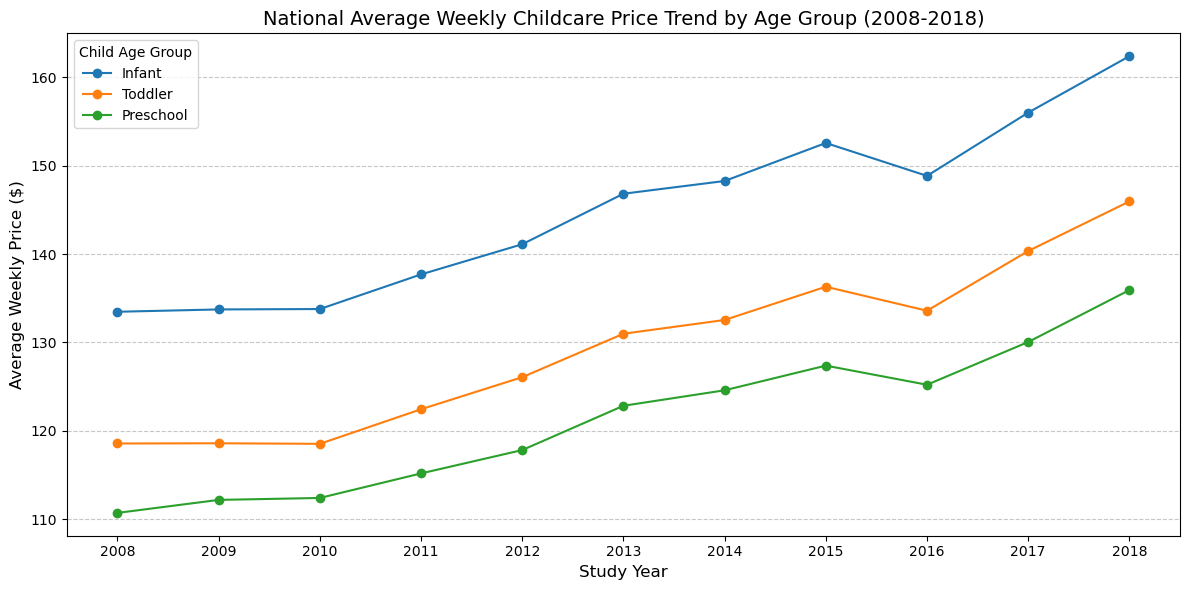

In [24]:
# Select relevant columns
price_columns = ['StudyYear', 'MCInfant', 'MCToddler', 'MCPreschool']
df_prices = df[price_columns]

# Calculate the national average price for each age group for each year
national_avg_prices = df_prices.groupby('StudyYear')[['MCInfant', 'MCToddler', 'MCPreschool']].mean().reset_index()

# Rename columns
national_avg_prices.columns = ['Year', 'Infant', 'Toddler', 'Preschool']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(national_avg_prices['Year'], national_avg_prices['Infant'], marker='o', label='Infant')
plt.plot(national_avg_prices['Year'], national_avg_prices['Toddler'], marker='o', label='Toddler')
plt.plot(national_avg_prices['Year'], national_avg_prices['Preschool'], marker='o', label='Preschool')
plt.title('National Average Weekly Childcare Price Trend by Age Group (2008-2018)', fontsize=14)
plt.xlabel('Study Year', fontsize=12)
plt.ylabel('Average Weekly Price ($)', fontsize=12)
plt.xticks(national_avg_prices['Year'].astype(int))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Child Age Group')
plt.tight_layout()
plt.savefig('national_childcare_price_trend_matplotlib.png')

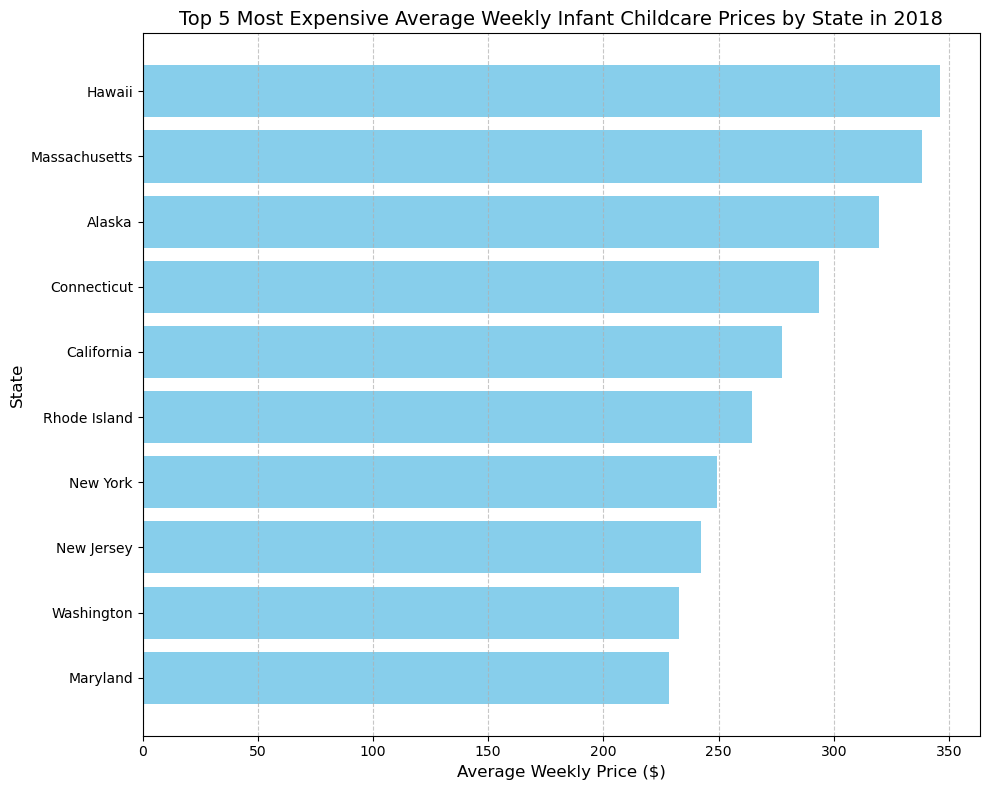

In [25]:
# Find the most recent year
max_year = df['StudyYear'].max()

# Filter for the most recent year
df_latest_year = df[df['StudyYear'] == max_year].copy()

# Calculate the average Infant Childcare Price for the last year
state_avg_infant_price = df_latest_year.groupby('State_Name')['MCInfant'].mean().reset_index()
state_avg_infant_price.columns = ['State', 'Average_Weekly_Infant_Price']

# drop rows with price as NA
state_avg_infant_price.dropna(subset=['Average_Weekly_Infant_Price'], inplace=True)

# Sort the states by price
state_avg_infant_price = state_avg_infant_price.sort_values('Average_Weekly_Infant_Price', ascending=False)

# Select most expensive states
top_expensive = state_avg_infant_price.head(10)

# Reverse the order
top_expensive_for_plot = top_expensive.iloc[::-1]
# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_expensive_for_plot['State'], top_expensive_for_plot['Average_Weekly_Infant_Price'], color='skyblue')
plt.title(f'Top 5 Most Expensive Average Weekly Infant Childcare Prices by State in {max_year}', fontsize=14)
plt.xlabel('Average Weekly Price ($)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().tick_params(axis='y', labelsize=10) 
plt.tight_layout()
plt.savefig('state_infant_childcare_price_comparison_matplotlib.png')